In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree

In [6]:
df = pd.read_csv('/Users/34633/kagglada/complex-master-learn-and-get-your-mark/train.csv', sep=',', encoding = 'latin1')
df_test = pd.read_csv('/Users/34633/kagglada/complex-master-learn-and-get-your-mark/test.csv', sep=',', encoding = 'latin1')
df.head()

,Id,PreferedAlbum,Vinyl,AvgTime,TicketInfo,Opinion,Concert,Age,VIP,Food,Drinks,FreePass
0,01/2362,Head Hunters,False,3.055,B/140/N,"Everything worked, yet nothing surprised me. (...",NYC12-5pm,22.0,False,170.0,1.0,True
1,04/0599,Bright Size Life,True,2.510,LB/124/N,"Solid gigânothing magical, nothing awful. (N...",NYC12-5pm,9.0,False,0.0,0.0,True
2,01/3223,Head Hunters,False,0.803,CB/523/N,"Guitars were sharp, but everything else felt r...",NYC12-5pm,NaN,False,815.0,37.0,False
3,01/1966,Kind of Blue,False,0.568,A/81/XL,Feedback screamed louder than the guitars. Dis...,FL16-7pm,36.0,False,1427.0,1395.0,False
4,01/8850,Bright Size Life,False,0.034,B/580/XL,NaN,NYC12-5pm,16.0,False,1299.0,0.0,False


In [7]:
df.columns.tolist()


['Id',
 'PreferedAlbum',
 'Vinyl',
 'AvgTime',
 'TicketInfo',
 'Opinion',
 'Concert',
 'Age',
 'VIP',
 'Food',
 'Drinks',
 'FreePass']

In [8]:
df_test.shape

(2854, 11)

FreePass
True     5216
False    4900
Name: count, dtype: int64


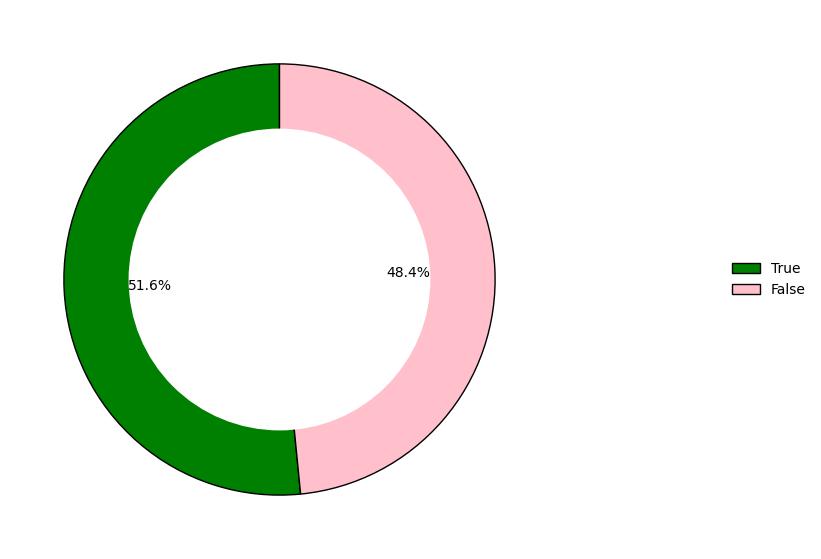

In [9]:
freepass = df['FreePass']
count_freepass = freepass.value_counts()
print(count_freepass)

labels = count_freepass.index.tolist()
colors = []
color_map = {
    True: 'green', 
    False: 'pink'
}
colors = [color_map.get(label, 'gray') for label in labels]


plt.figure(figsize=(7, 7))
plt.pie(count_freepass.values, autopct='%.1f%%', startangle=90, colors=colors,wedgeprops={'edgecolor': 'black', 'linewidth': 1})
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.legend(
    labels,
    loc="center right",
    bbox_to_anchor=(1, 0, 0.5, 1), frameon=False
)
plt.show()

In [10]:
df_sinfree = df.drop(columns=[df.columns[-1]])
df_sinfree.head()

,Id,PreferedAlbum,Vinyl,AvgTime,TicketInfo,Opinion,Concert,Age,VIP,Food,Drinks
0,01/2362,Head Hunters,False,3.055,B/140/N,"Everything worked, yet nothing surprised me. (...",NYC12-5pm,22.0,False,170.0,1.0
1,04/0599,Bright Size Life,True,2.510,LB/124/N,"Solid gigânothing magical, nothing awful. (N...",NYC12-5pm,9.0,False,0.0,0.0
2,01/3223,Head Hunters,False,0.803,CB/523/N,"Guitars were sharp, but everything else felt r...",NYC12-5pm,NaN,False,815.0,37.0
3,01/1966,Kind of Blue,False,0.568,A/81/XL,Feedback screamed louder than the guitars. Dis...,FL16-7pm,36.0,False,1427.0,1395.0
4,01/8850,Bright Size Life,False,0.034,B/580/XL,NaN,NYC12-5pm,16.0,False,1299.0,0.0


In [11]:
X = df_sinfree.values
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, train_size=0.7, random_state=42)
clf = tree.DecisionTreeClassifier(max_depth=None)
clf.fit(X_train,y_train)
yhat = clf.predict(X_train)

NameError: name 'y' is not defined

a partir del codigo de ana (CONTINUACION)

In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve

X = df.drop(columns=["Id", "FreePass"])
y = df["FreePass"].astype(int)

def prepare_data(df, is_train=True):
    df_fe = df.copy()
    
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    if 'Id' in df_fe.columns and not is_train:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = df.get('Id', None)

    df_fe["Food_Drinks_Sum"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe["Food_Drinks_Ratio"] = df_fe["Food"] / (df_fe["Drinks"] + 1)
    df_fe["Total_Spending"] = df_fe["Food"] + df_fe["Drinks"] + df_fe.get("Vinyl", 0)
    
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    df_fe['Age_Sq'] = df_fe['Age'] ** 2
    
    df_fe['Opinion'] = df_fe['Opinion'].astype(str).replace('nan', '')
    df_fe['Opinion_Length'] = df_fe['Opinion'].str.len()
    df_fe['Has_Opinion'] = (df_fe['Opinion_Length'] > 0).astype(int)
    
    keywords = ['love', 'great', 'amazing', 'excellent', 'best', 'good']
    for word in keywords:
        df_fe[f'Opinion_{word}'] = df_fe['Opinion'].str.contains(word, case=False).astype(int)
    
    df_fe = df_fe.drop(columns=['Opinion'])
    
    ticket_parts = df_fe["TicketInfo"].str.split("/", expand=True)
    df_fe["Ticket_Zone"] = ticket_parts[0]
    df_fe["Ticket_Row"] = pd.to_numeric(ticket_parts[1], errors='coerce')
    df_fe["Ticket_Size"] = ticket_parts[2]
    
    df_fe['Ticket_Row'] = df_fe['Ticket_Row'].fillna(df_fe['Ticket_Row'].median())
    df_fe['Is_Front_Row'] = (df_fe['Ticket_Row'] <= 10).astype(int)
    df_fe['Is_VIP_Zone'] = df_fe['Ticket_Zone'].str.contains('VIP', case=False, na=False).astype(int)
    
    df_fe = df_fe.drop(columns=['TicketInfo'])
    
    df_fe['Age_Group'] = pd.cut(df_fe['Age'], 
                               bins=[0, 18, 30, 45, 60, 120],
                               labels=['Kid', 'Young', 'Adult', 'Senior', 'Elder'])
    
    for col in df_fe.columns:
        if df_fe[col].dtype == 'bool':
            df_fe[col] = df_fe[col].astype(int)
            
    return df_fe, ids

X_fe, _ = prepare_data(X, is_train=True)

num_cols = X_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

model = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.02,
    max_depth=8,
    max_leaf_nodes=40,
    min_samples_leaf=20,
    l2_regularization=1.0,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42,
    class_weight='balanced'
)

full_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(full_pipeline, X_fe, y, cv=skf, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

full_pipeline.fit(X_train, y_train)

y_proba_val = full_pipeline.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 80)
best_acc = 0
best_threshold = 0.5

for t in thresholds:
    acc = accuracy_score(y_val, y_proba_val > t)
    if acc > best_acc:
        best_acc = acc
        best_threshold = t

print(f"Mejor Accuracy en Val: {best_acc:.4f} usando threshold: {best_threshold:.2f}")

X_test_fe, test_ids = prepare_data(df_test, is_train=False)
X_test_fe = X_test_fe.reindex(columns=X_fe.columns, fill_value=0)

y_proba_test = full_pipeline.predict_proba(X_test_fe)[:, 1]
final_preds = (y_proba_test > best_threshold).astype(bool)

submission = pd.DataFrame({
    "Id": test_ids,
    "FreePass": final_preds
})

submission.to_csv("submission_optimized.csv", index=False)
print("Archivo 'submission_optimized.csv' generado con éxito.")

CV Accuracy: 0.8160 (+/- 0.0091)
Mejor Accuracy en Val: 0.8147 usando threshold: 0.51
Archivo 'submission_optimized.csv' generado con éxito.


In [14]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# =====================
# 1. FUNCIÓN PARA PREPARAR DATOS (USADA EN TRAIN Y TEST)
# =====================
def prepare_data(df, is_train=True):
    """Prepara datos de manera consistente para train y test"""
    df_fe = df.copy()
    
    # Eliminar columnas que no queremos
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    # Guardar Id si existe (para submission)
    if 'Id' in df_fe.columns and is_train == False:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = None
    
    # Features básicas
    df_fe["Food_Drinks"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe["Spending"] = df_fe["Food"] * df_fe["Drinks"]
    
    # Age features
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    df_fe['Is_Young'] = (df_fe['Age'] < 30).astype(int)
    df_fe['Is_Senior'] = (df_fe['Age'] > 50).astype(int)
    
    # Opinion features
    df_fe['Opinion_Length'] = df_fe['Opinion'].str.len().fillna(0)
    df_fe['Has_Opinion'] = df_fe['Opinion'].notna().astype(int)
    
    # TicketInfo
    df_fe["Ticket_Zone"] = df_fe["TicketInfo"].str.split("/").str[0]
    df_fe["Ticket_Row"] = pd.to_numeric(df_fe["TicketInfo"].str.split("/").str[1], errors='coerce')
    df_fe["Ticket_Size"] = df_fe["TicketInfo"].str.split("/").str[2]
    df_fe['Is_Front_Row'] = (df_fe['Ticket_Row'] <= 10).astype(int)
    df_fe['Is_VIP_Zone'] = df_fe['Ticket_Zone'].str.contains('VIP', case=False, na=False).astype(int)
    
    # Age Group
    df_fe['Age_Group'] = pd.cut(df_fe['Age'], 
                               bins=[0, 25, 35, 45, 55, 100],
                               labels=['<25', '25-35', '35-45', '45-55', '55+'])
    
    # Imputar categóricas
    # for col in ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Size', 'Age_Group']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')
    
    # for col in ['Vinyl', 'VIP']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')
    
    # Asegurar tipos
    for col in df_fe.columns:
        if df_fe[col].dtype == 'bool':
            df_fe[col] = df_fe[col].astype(int)
    
    return df_fe, ids

# =====================
# 2. PREPARAR DATOS DE TRAIN
# =====================
print("Preparando datos de entrenamiento...")
X_fe, _ = prepare_data(X, is_train=True)

# Identificar columnas
num_cols = X_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Train - Columnas numéricas: {len(num_cols)}")
print(f"Train - Columnas categóricas: {len(cat_cols)}")
print(f"Train - Total columnas: {len(num_cols) + len(cat_cols)}")

# =====================
# 3. CREAR PIPELINE
# =====================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Pipeline completo
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(
        max_iter=1000,
        learning_rate=0.05,
        max_depth=7,
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        random_state=42,
        class_weight='balanced'
    ))
])

# =====================
# 4. ENTRENAR MODELO
# =====================
print("\nEntrenando modelo...")
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

pipeline.fit(X_train, y_train)

# Evaluar
from sklearn.metrics import f1_score, accuracy_score
y_pred = pipeline.predict(X_val)
print(f"F1 Score en validation: {f1_score(y_val, y_pred):.4f}")
print(f"Accuracy en validation: {accuracy_score(y_val, y_pred):.4f}")

# =====================
# 5. PREPARAR Y PREDECIR TEST
# =====================
print("\nPreparando datos de test...")
X_test_fe, test_ids = prepare_data(df_test, is_train=False)

# Verificar que test tenga las mismas columnas que train
print(f"Test - Total columnas: {X_test_fe.shape[1]}")

# Asegurar que test tiene las mismas columnas en el mismo orden
missing_cols = set(X_fe.columns) - set(X_test_fe.columns)
extra_cols = set(X_test_fe.columns) - set(X_fe.columns)

if missing_cols:
    print(f"Columnas faltantes en test: {missing_cols}")
    # Añadir columnas faltantes con valores por defecto
    for col in missing_cols:
        X_test_fe[col] = 0 if X_fe[col].dtype in ['int64', 'float64'] else 'Unknown'

if extra_cols:
    print(f"Columnas extra en test: {extra_cols}")
    # Eliminar columnas extra
    X_test_fe = X_test_fe.drop(columns=list(extra_cols))

# Reordenar columnas para que coincidan con train
X_test_fe = X_test_fe[X_fe.columns]

print(f"Test después de ajuste - Total columnas: {X_test_fe.shape[1]}")

# =====================
# 6. HACER PREDICCIONES
# =====================
print("\nHaciendo predicciones...")
y_proba_test = pipeline.predict_proba(X_test_fe)[:, 1]

# Aplicar threshold (ajusta según lo que optimizaste)
best_threshold = 0.5
preds = (y_proba_test > best_threshold).astype(int)

# =====================
# 7. CREAR SUBMISSION
# =====================
submission = pd.DataFrame({
    "Id": test_ids,
    "FreePass": preds.astype(bool)
})

print(f"\nSubmission creado:")
print(f"Número de predicciones: {len(submission)}")
print(f"FreePass positivos: {submission['FreePass'].sum()} ({submission['FreePass'].mean()*100:.1f}%)")

# Guardar
submission.to_csv("submission_final.csv", index=False)
print("Guardado como 'submission_final.csv'")

Preparando datos de entrenamiento...
Train - Columnas numéricas: 12
Train - Columnas categóricas: 9
Train - Total columnas: 21

Entrenando modelo...
F1 Score en validation: 0.8180
Accuracy en validation: 0.8177

Preparando datos de test...
Test - Total columnas: 21
Test después de ajuste - Total columnas: 21

Haciendo predicciones...

Submission creado:
Número de predicciones: 2854
FreePass positivos: 1371 (48.0%)
Guardado como 'submission_final.csv'


In [17]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

def prepare_data(df, is_train=True):
    df_fe = df.copy()
    
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    if 'Id' in df_fe.columns and not is_train:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = df.get('Id', None)

    df_fe["Total_Spending"] = df_fe["Food"] + df_fe["Drinks"] + df_fe.get("Vinyl", 0)
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    
    df_fe['Opinion'] = df_fe['Opinion'].astype(str).replace('nan', '').str.lower()
    df_fe['Op_Len'] = df_fe['Opinion'].str.len()
    
    keywords = ['love', 'great', 'amazing', 'excellent', 'best', 'good']
    for word in keywords:
        df_fe[f'Op_{word}'] = df_fe['Opinion'].str.contains(word).astype(int)
    df_fe = df_fe.drop(columns=['Opinion'])
    
    tk = df_fe["TicketInfo"].str.split("/", expand=True)
    df_fe["Tk_Zone"] = tk[0].fillna("NA")
    df_fe["Tk_Row"] = pd.to_numeric(tk[1], errors='coerce').fillna(-1)
    df_fe["Tk_Size"] = tk[2].fillna("NA")
    df_fe = df_fe.drop(columns=['TicketInfo'])
    
    # Aseguramos que las categorías sean strings para el OrdinalEncoder
    cat_cols_local = df_fe.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols_local:
        df_fe[col] = df_fe[col].astype(str)
            
    return df_fe, ids

X_fe, _ = prepare_data(X, is_train=True)
num_cols = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_fe.select_dtypes(exclude=[np.number]).columns.tolist()

# PIPELINE DE ALTA CAPACIDAD
preprocessor = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sca", RobustScaler())]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols)
])

# Modelo con más capacidad: más iteraciones y más profundidad
model = HistGradientBoostingClassifier(
    max_iter=1000,           # Mayor capacidad de aprendizaje
    learning_rate=0.01,      # Paso más lento para mayor precisión
    max_depth=7,            # Árboles más profundos
    max_leaf_nodes=24,       # Más complejidad por árbol
    l2_regularization=1.5,   # Evitamos overfitting por la alta capacidad
    early_stopping=True,
    n_iter_no_change=25,
    random_state=42
    # Eliminado class_weight='balanced' para maximizar Accuracy puro
)

full_pipeline = Pipeline([("prep", preprocessor), ("model", model)])

# VALIDACIÓN ROBUSTA
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(full_pipeline, X_fe, y, cv=skf, scoring='accuracy')
print(f"CV Accuracy (Media): {cv_scores.mean():.4f}")

# ENTRENAMIENTO Y BÚSQUEDA DE UMBRAL
X_train, X_val, y_train, y_val = train_test_split(X_fe, y, test_size=0.15, stratify=y, random_state=42)
full_pipeline.fit(X_train, y_train)

y_proba_val = full_pipeline.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.3, 0.7, 100)
best_acc, best_t = 0, 0.5

for t in thresholds:
    acc = accuracy_score(y_val, y_proba_val > t)
    if acc > best_acc:
        best_acc, best_t = acc, t

print(f"Accuracy Final en Val: {best_acc:.4f} con Umbral: {best_t:.2f}")

# PREDICCIÓN TEST
X_test_fe, test_ids = prepare_data(df_test, is_train=False)
X_test_fe = X_test_fe.reindex(columns=X_fe.columns, fill_value='Unknown')

y_proba_test = full_pipeline.predict_proba(X_test_fe)[:, 1]
final_preds = (y_proba_test > best_t).astype(bool)

submission = pd.DataFrame({"Id": test_ids, "FreePass": final_preds})
submission.to_csv("submission_max_cap.csv", index=False)

CV Accuracy (Media): 0.7765
Accuracy Final en Val: 0.7833 con Umbral: 0.51


In [27]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def prepare_data(df, is_train=True):
    df_fe = df.copy()
    
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    if 'Id' in df_fe.columns and not is_train:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = df.get('Id', None)

    # Solo las variables que realmente importan
    df_fe["Total_Spending"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    
    # Simplificación de TicketInfo (Menos es más)
    tk = df_fe["TicketInfo"].str.split("/", expand=True)
    df_fe["Tk_Zone"] = tk[0].fillna("NA")
    df_fe["Tk_Row"] = pd.to_numeric(tk[1], errors='coerce').fillna(-1)
    df_fe = df_fe.drop(columns=['TicketInfo', 'Opinion']) # Quitamos Opinion para evitar ruido de texto
    
    # Forzar tipos para evitar errores de encoder
    cat_features = df_fe.select_dtypes(exclude=[np.number]).columns
    for col in cat_features:
        df_fe[col] = df_fe[col].astype(str)
            
    return df_fe, ids

X_fe, _ = prepare_data(X, is_train=True)
num_cols = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_fe.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sca", StandardScaler())]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols)
])

# Modelos con parámetros más conservadores para evitar Overfitting
model_hgb = HistGradientBoostingClassifier(
    max_iter=300,
    learning_rate=0.05,
    max_depth=5, # Reducimos profundidad
    random_state=42
)

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10, # Reducimos profundidad
    random_state=42
)

ensemble_model = VotingClassifier(
    estimators=[('hgb', model_hgb), ('rf', model_rf)],
    voting='soft'
)

full_pipeline = Pipeline([("prep", preprocessor), ("ensemble", ensemble_model)])

# Usamos una partición de validación más grande para estar seguros
X_train, X_val, y_train, y_val = train_test_split(X_fe, y, test_size=0.25, stratify=y, random_state=42)

print("Entrenando...")
full_pipeline.fit(X_train, y_train)

# Evaluación directa sin threshold complejo (para ver la base)
y_pred_val = full_pipeline.predict(X_val)
print(f"Accuracy base en Validación: {accuracy_score(y_val, y_pred_val):.5f}")

X_test_fe, test_ids = prepare_data(df_test, is_train=False)
X_test_fe = X_test_fe.reindex(columns=X_fe.columns, fill_value='Unknown')

final_preds = full_pipeline.predict(X_test_fe)

submission = pd.DataFrame({"Id": test_ids, "FreePass": final_preds.astype(bool)})
#submission.to_csv("submission_rescue.csv", index=False)

Entrenando...
Accuracy base en Validación: 0.81574


In [26]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def prepare_data(df, is_train=True):
    df_fe = df.copy()
    
    # 1. Limpieza de columnas innecesarias
    cols_to_drop = ['Id', 'AvgTime']
    df_fe = df_fe.drop(columns=[c for c in cols_to_drop if c in df_fe.columns])

    # 2. Ingeniería de variables de Gasto (Crucial)
    for col in ['Food', 'Drinks', 'Vinyl']:
        if col not in df_fe.columns:
            df_fe[col] = 0
    
    df_fe["TotalSpend"] = df_fe["Food"] + df_fe["Drinks"] + df_fe["Vinyl"]
    # Variable de interacción: Gasto por unidad de edad
    df_fe["Spend_Age_Ratio"] = df_fe["TotalSpend"] / (df_fe["Age"] + 1)

    # 3. Extracción inteligente de TicketInfo
    if 'TicketInfo' in df_fe.columns:
        tk = df_fe["TicketInfo"].str.split("/", expand=True)
        df_fe["Zone"] = tk[0].fillna("NA").astype(str).str.upper()
        df_fe["Row"] = pd.to_numeric(tk[1], errors='coerce').fillna(-1)
        # Variable booleana de alta importancia: ¿Es zona VIP?
        df_fe["Is_VIP"] = df_fe["Zone"].str.contains("VIP").astype(int)
        df_fe = df_fe.drop(columns=['TicketInfo'])

    # 4. Procesamiento de Opinión (Longitud como proxy de interés)
    if 'Opinion' in df_fe.columns:
        df_fe['Op_Len'] = df_fe['Opinion'].astype(str).str.len()
        df_fe = df_fe.drop(columns=['Opinion'])

    # 5. Estandarización de tipos
    if 'Age' in df_fe.columns:
        df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())

    for col in df_fe.columns:
        if not np.issubdtype(df_fe[col].dtype, np.number):
            df_fe[col] = df_fe[col].astype(str).str.upper()
            
    ids = df.get('Id', None)
    return df_fe, ids

# Preparación de datos
X_fe, _ = prepare_data(X, is_train=True)
y = y.astype(int)

num_features = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_fe.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocesador con OrdinalEncoder optimizado
preprocessor = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sca", StandardScaler())]), num_features),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="NA")),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_features)
])

# MODELO DE ALTO RENDIMIENTO (Aumentamos capacidad controlada)
model = HistGradientBoostingClassifier(
    max_iter=600,            # Más intentos para encontrar patrones
    learning_rate=0.03,      # Un poco más lento para no pasarse de frenada
    max_depth=7,             # Profundidad media para capturar interacciones
    max_leaf_nodes=31,       # Estándar de la industria para evitar overfitting
    l2_regularization=2.0,   # Regularización moderada
    min_samples_leaf=25,     # Evita que el modelo cree reglas para 1 solo usuario
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

pipeline = Pipeline([("prep", preprocessor), ("model", model)])

# Validación con split estratificado
X_train, X_val, y_train, y_val = train_test_split(X_fe, y, test_size=0.15, stratify=y, random_state=42)

pipeline.fit(X_train, y_train)

# Evaluación
val_preds = pipeline.predict(X_val)
print(f"Accuracy de Validación Optimizado: {accuracy_score(y_val, val_preds):.4f}")

# --- PREDICCIÓN FINAL PARA TEST ---
X_test_fe, test_ids = prepare_data(df_test, is_train=False)
X_test_fe = X_test_fe.reindex(columns=X_fe.columns, fill_value="NA")

test_preds = pipeline.predict(X_test_fe)

submission = pd.DataFrame({"Id": test_ids, "FreePass": test_preds.astype(bool)})
submission.to_csv("submission_high_performance.csv", index=False)

Accuracy de Validación Optimizado: 0.7885


In [48]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.set_option('future.no_silent_downcasting', True)

def prepare_data(df, is_train=True):
    df_fe = df.copy()
    
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    if 'Id' in df_fe.columns:
        ids = df_fe['Id']
        if not is_train:
            df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = df.get('Id', None)

    # Variables de gasto: Ahora mantenemos Food y Drinks por separado
    # dado que el heatmap mostró una interacción importante.
    df_fe["Total_Spending"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    
    # Procesamiento de Ticket
    tk = df_fe["TicketInfo"].str.split("/", expand=True)
    df_fe["Tk_Zone"] = tk[0].fillna("NA")
    df_fe["Tk_Row"] = pd.to_numeric(tk[1], errors='coerce').fillna(-1)
    
    # Variables Booleanas Críticas (VIP y Vinyl)
    # Corregimos el aviso de downcasting con infer_objects
    df_fe['VIP'] = df_fe['VIP'].fillna(df_fe['VIP'].mode()[0]).infer_objects(copy=False)
    df_fe['Vinyl'] = df_fe['Vinyl'].fillna(df_fe['Vinyl'].mode()[0]).infer_objects(copy=False)
    
    # Texto: Mantenemos la opinión para el TfidfVectorizer
    df_fe['Opinion'] = df_fe['Opinion'].fillna("")
    
    df_fe = df_fe.drop(columns=['TicketInfo'])
    
    # Aseguramos que las categóricas sean strings
    cat_features = ['Tk_Zone', 'PreferedAlbum', 'Concert', 'VIP', 'Vinyl']
    for col in cat_features:
        if col in df_fe.columns:
            df_fe[col] = df_fe[col].astype(str)
            
    return df_fe, ids

# Preparación de datos
X_fe, _ = prepare_data(X, is_train=True)

num_cols = ['Age', 'Total_Spending', 'Tk_Row', 'Food', 'Drinks']
cat_cols = ['Tk_Zone', 'PreferedAlbum', 'Concert', 'VIP', 'Vinyl']
text_col = 'Opinion'

# Pipeline con procesamiento de texto y variables densas
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")), 
        ("sca", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols),
    ("text", TfidfVectorizer(
        max_features=100,      # Aumentado para captar palabras clave
        ngram_range=(1, 2),    # Bigramas para captar el contexto
        stop_words='english'
    ), text_col)
], sparse_threshold=0)

# Modelo Gradient Boosting con más profundidad para captar interacciones (Food x Drinks)
model_gb = GradientBoostingClassifier(
    n_estimators=1200,     # Suficientes árboles para aprender del texto y VIP/Vinyl
    learning_rate=0.01,    # Paso lento para precisión máxima
    max_depth=5,           # Profundidad 5 para ver interacciones de 5 variables a la vez
    min_samples_leaf=15,   
    subsample=0.75,        # Aleatoriedad para evitar overfitting
    random_state=42
)

full_pipeline = Pipeline([
    ("prep", preprocessor), 
    ("model", model_gb)
])

# Entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.20, stratify=y, random_state=42
)

full_pipeline.fit(X_train, y_train)
y_pred_val = full_pipeline.predict(X_val)
print(f"Accuracy Final Optimizada: {accuracy_score(y_val, y_pred_val):.5f}")

# Predicción de Test
X_test_fe, test_ids = prepare_data(df_test, is_train=False)
X_test_fe = X_test_fe.reindex(columns=X_fe.columns, fill_value="")
final_preds = full_pipeline.predict(X_test_fe)

submission = pd.DataFrame({"Id": test_ids, "FreePass": final_preds.astype(bool)})

Accuracy Final Optimizada: 0.81719


In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ----------------------------------
# Feature engineering (IGUAL)
# ----------------------------------
def prepare_data(df, is_train=True):
    df_fe = df.copy()

    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])

    if 'Id' in df_fe.columns:
        ids = df_fe['Id']
        if not is_train:
            df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = None

    df_fe["Total_Spending"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())

    tk = df_fe["TicketInfo"].str.split("/", expand=True)
    df_fe["Tk_Zone"] = tk[0].fillna("NA")
    df_fe["Tk_Row"] = pd.to_numeric(tk[1], errors='coerce').fillna(-1)

    df_fe['VIP'] = df_fe['VIP'].fillna(df_fe['VIP'].mode()[0]).infer_objects(copy=False)
    df_fe['Vinyl'] = df_fe['Vinyl'].fillna(df_fe['Vinyl'].mode()[0]).infer_objects(copy=False)

    df_fe['Opinion'] = df_fe['Opinion'].fillna("")

    df_fe = df_fe.drop(columns=['TicketInfo'])

    cat_features = ['Tk_Zone', 'PreferedAlbum', 'Concert', 'VIP', 'Vinyl']
    for col in cat_features:
        df_fe[col] = df_fe[col].astype(str)

    return df_fe, ids

# ----------------------------------
# Load data
# ----------------------------------
# X, y, df_test deben existir
X_fe, _ = prepare_data(X, is_train=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------------
# ColumnTransformer (IGUAL)
# ----------------------------------
num_cols = ['Age', 'Total_Spending', 'Tk_Row', 'Food', 'Drinks']
cat_cols = ['Tk_Zone', 'PreferedAlbum', 'Concert', 'VIP', 'Vinyl']
text_col = 'Opinion'

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sca", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols),

    ("text", TfidfVectorizer(
        max_features=100,
        ngram_range=(1, 2),
        stop_words="english"
    ), text_col)
], sparse_threshold=0)

# ----------------------------------
# Transform data
# ----------------------------------
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

# ----------------------------------
# Target → one-hot (softmax)
# ----------------------------------
num_classes = len(np.unique(y_train))

y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes)

# ----------------------------------
# Neural Network (TABULAR CORRECTA)
# ----------------------------------
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_proc.shape[1],)),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ----------------------------------
# Training
# ----------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

model.fit(
    X_train_proc,
    y_train_oh,
    validation_data=(X_val_proc, y_val_oh),
    epochs=300,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# ----------------------------------
# Validation accuracy
# ----------------------------------
val_probs = model.predict(X_val_proc)
val_preds = np.argmax(val_probs, axis=1)

print(f"Neural Network Accuracy: {accuracy_score(y_val, val_preds):.5f}")

# ----------------------------------
# Test prediction
# ----------------------------------
X_test_fe, test_ids = prepare_data(df_test, is_train=False)
X_test_proc = preprocessor.transform(X_test_fe)

test_probs = model.predict(X_test_proc)
test_preds = np.argmax(test_probs, axis=1)

submission = pd.DataFrame({
    "Id": test_ids,
    "FreePass": test_preds.astype(bool)
})

submission.to_csv("submission_nn.csv", index=False)
print("submission_nn.csv saved")


ModuleNotFoundError: No module named 'tensorflow'

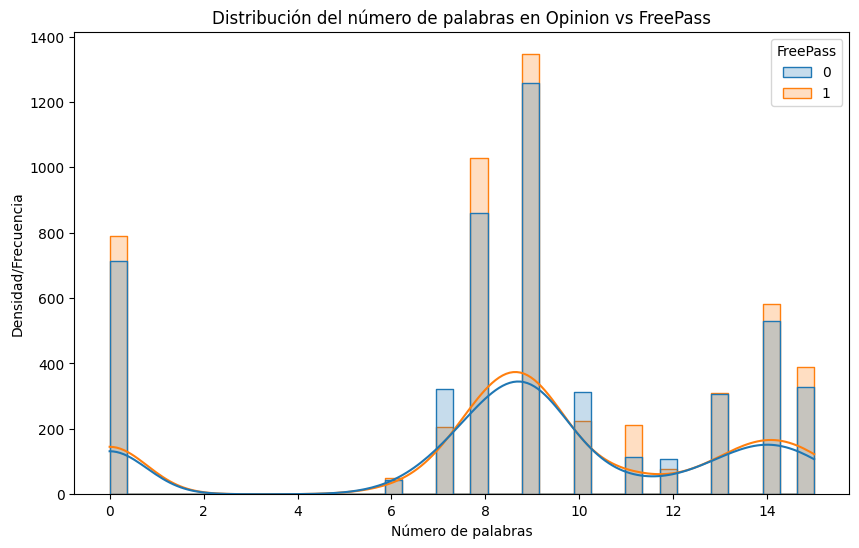

Estadísticas descriptivas del número de palabras por clase:
           count     mean       std  min  25%  50%   75%   max
FreePass                                                      
0         4900.0  8.73000  4.324456  0.0  8.0  9.0  12.0  15.0
1         5216.0  8.74329  4.408117  0.0  8.0  9.0  12.0  15.0


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_check = X.copy()
X_check['FreePass'] = y
X_check['Opinion_Word_Count'] = X_check['Opinion'].fillna("").apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=X_check, x='Opinion_Word_Count', hue='FreePass', kde=True, element="step", common_norm=False)
plt.title("Distribución del número de palabras en Opinion vs FreePass")
plt.xlabel("Número de palabras")
plt.ylabel("Densidad/Frecuencia")
plt.show()

print("Estadísticas descriptivas del número de palabras por clase:")
print(X_check.groupby('FreePass')['Opinion_Word_Count'].describe())

  Sentiment  Conversion_Rate  Count
0   Missing         0.526281   1503
1  Negative         0.422179    514
2   Neutral         0.507511   4993
3  Positive         0.538957   3106


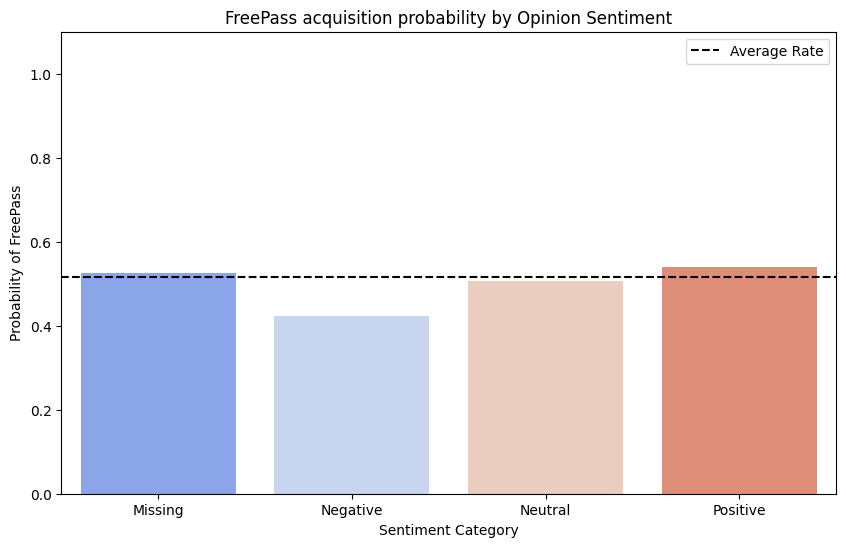

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_sentiment_impact(df, target):
    df_check = df.copy()
    df_check['Target'] = target
    
    pos_words = ['good', 'great', 'excellent', 'amazing', 'love', 'best', 'awesome', 'perfect', 'fantastic']
    neg_words = ['bad', 'worst', 'terrible', 'awful', 'hate', 'disappointing', 'poor', 'boring', 'waste']
    
    def get_sentiment_label(text):
        if pd.isna(text): 
            return 'Missing'
        t = str(text).lower()
        p = sum(1 for w in pos_words if w in t)
        n = sum(1 for w in neg_words if w in t)
        if p > n: 
            return 'Positive'
        if n > p: 
            return 'Negative'
        return 'Neutral'

    df_check['Sentiment_Label'] = df_check['Opinion'].apply(get_sentiment_label)
    
    summary = df_check.groupby('Sentiment_Label')['Target'].agg(['mean', 'count']).reset_index()
    summary.columns = ['Sentiment', 'Conversion_Rate', 'Count']
    
    print(summary)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=summary, x='Sentiment', y='Conversion_Rate', hue='Sentiment', palette='coolwarm', legend=False)
    plt.axhline(target.mean(), color='black', linestyle='--', label='Average Rate')
    plt.title("FreePass acquisition probability by Opinion Sentiment")
    plt.ylabel("Probability of FreePass")
    plt.xlabel("Sentiment Category")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()

analyze_sentiment_impact(X, y)

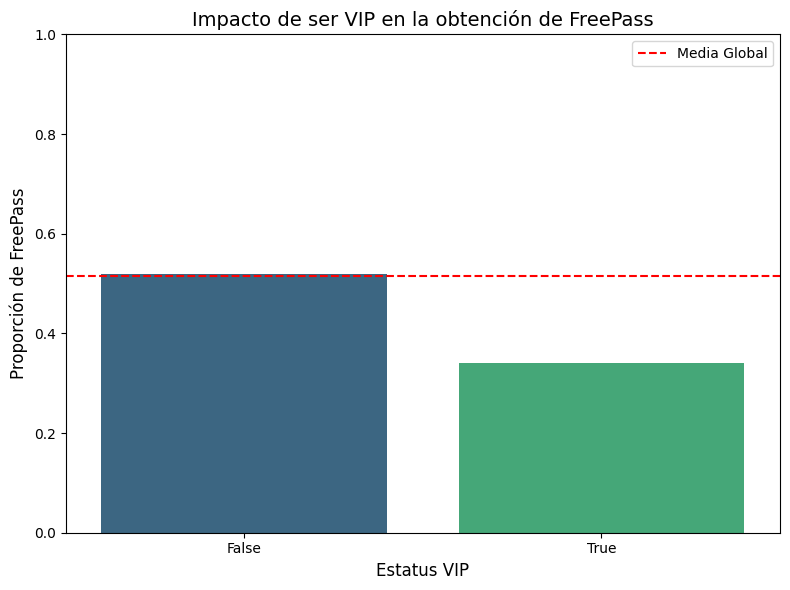

Frecuencias y tasas de éxito por categoría VIP:
           mean  count
VIP                   
False  0.519541   9672
True   0.339713    209


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_vip = X.copy()
df_vip['FreePass'] = y

vip_analysis = df_vip.groupby('VIP')['FreePass'].mean().reset_index()
vip_analysis.columns = ['Es_VIP', 'Tasa_Conversion']

plt.figure(figsize=(8, 6))
sns.barplot(data=vip_analysis, x='Es_VIP', y='Tasa_Conversion', hue='Es_VIP', palette='viridis', legend=False)
plt.axhline(y.mean(), color='red', linestyle='--', label='Media Global')

plt.title('Impacto de ser VIP en la obtención de FreePass', fontsize=14)
plt.xlabel('Estatus VIP', fontsize=12)
plt.ylabel('Proporción de FreePass', fontsize=12)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

print("Frecuencias y tasas de éxito por categoría VIP:")
print(df_vip.groupby('VIP')['FreePass'].agg(['mean', 'count']))

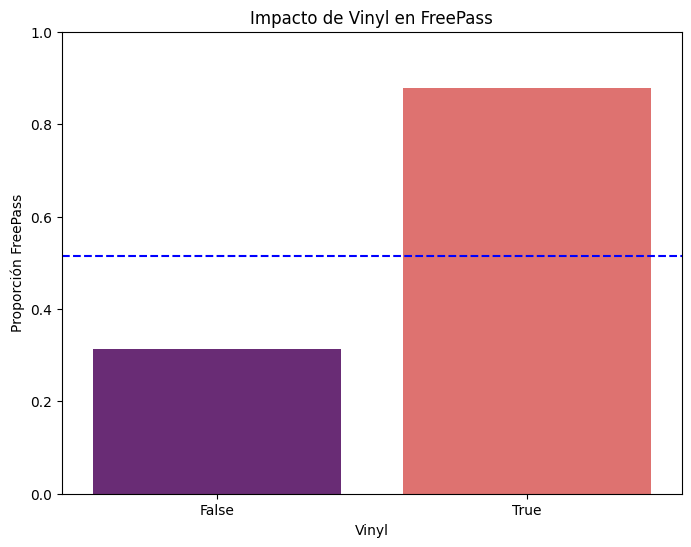

   Vinyl      mean  count
0  False  0.312579   6296
1   True  0.877345   3571


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_vinyl = X.copy()
df_vinyl['FreePass'] = y
vinyl_stats = df_vinyl.groupby('Vinyl')['FreePass'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=vinyl_stats, x='Vinyl', y='mean', hue='Vinyl', palette='magma', legend=False)
plt.axhline(y.mean(), color='blue', linestyle='--')
plt.title('Impacto de Vinyl en FreePass')
plt.ylabel('Proporción FreePass')
plt.ylim(0, 1)
plt.show()

print(vinyl_stats)

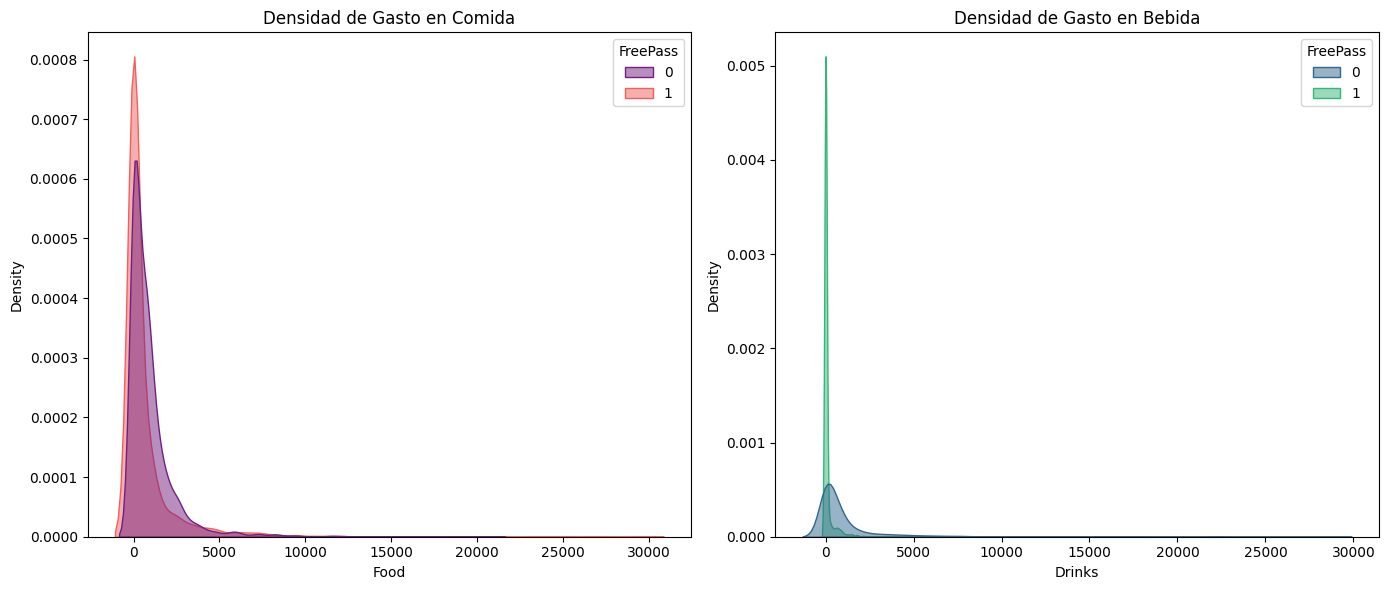

C:\Users\34633\AppData\Local\Temp\ipykernel_15060\204357535.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_plot.pivot_table(index='Food_Bin', columns='Drinks_Bin', values='FreePass', aggfunc='mean')


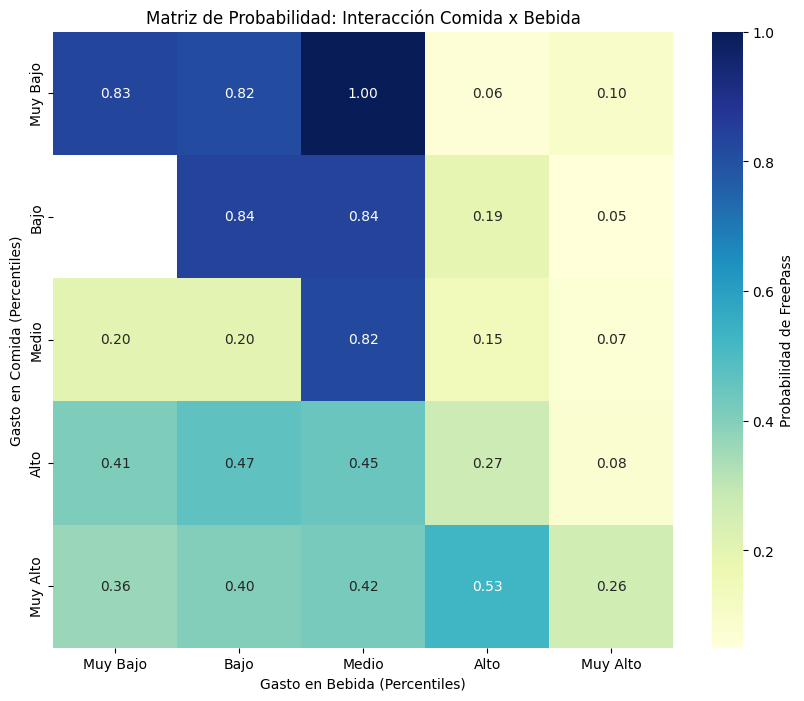

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_plot = X.copy()
df_plot['FreePass'] = y

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_plot, x='Food', hue='FreePass', fill=True, common_norm=False, palette="magma", alpha=.5)
plt.title('Densidad de Gasto en Comida')
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_plot, x='Drinks', hue='FreePass', fill=True, common_norm=False, palette="viridis", alpha=.5)
plt.title('Densidad de Gasto en Bebida')
plt.tight_layout()
plt.show()

df_plot['Food_Bin'] = pd.qcut(df_plot['Food'].rank(method='first'), q=5, labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])
df_plot['Drinks_Bin'] = pd.qcut(df_plot['Drinks'].rank(method='first'), q=5, labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])
heatmap_data = df_plot.pivot_table(index='Food_Bin', columns='Drinks_Bin', values='FreePass', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Probabilidad de FreePass'})
plt.title('Matriz de Probabilidad: Interacción Comida x Bebida')
plt.xlabel('Gasto en Bebida (Percentiles)')
plt.ylabel('Gasto en Comida (Percentiles)')
plt.show()